In [1]:
##ML / nerd shit import
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

# Rael import
import datetime
import os
import urllib
import json
import yfinance as yf

In [2]:
#### READ THIS BEFORE CONTINUING ####

### CHANGE THE FOLLOWING VARIABLES ###
stock_name = "SPY" #--> GIVE THE TICKER NAME


### START AND END_DATES, GIVE YYYY-MM-DD format
start_date = "2023-05-06"

end_date = "2023-05-13"

### CHOOSE INTERVAL OF TRAINING DATA, BEWARNED THAT IF YOUR START AND END, LONG, MIGHT NOT BE ABLE TO GET LARGE INTERVAL 

time_interval = "1m" ## LIST OF HISTORY: [“1m”, “2m”, “5m”, “15m”, “30m”, “60m”, “90m”, “1h”, “1d”, “5d”, “1wk”, “1mo”, “3mo”]


start_date_2 = "2023-05-14"
end_date_2 = "2023-05-21"

In [3]:
#for saving / upadting / testing?
#need to change, then can run the above!
curr_day_to_string = datetime.date.today()
cache_fname = "/historical/" + f"{stock_name}_{curr_day_to_string}.csv"

stock = yf.Ticker(stock_name) #save the stock_name
## TO change the historical values, try to stick to 1m granularity
data = pd.DataFrame(stock.history(start=start_date, end=end_date, interval=time_interval))
data_2 = pd.DataFrame(stock.history(start=start_date_2, end=end_date_2, interval=time_interval))

data_combined = pd.concat((data, data_2), axis=0)
data_combined

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Datetime,,,,,,,,
2023-05-08 09:30:00-04:00,412.970001,413.130005,412.880005,412.880005,1754494,0.0,0.0,0.0
2023-05-08 09:31:00-04:00,412.885010,412.885010,412.649994,412.690002,272947,0.0,0.0,0.0
2023-05-08 09:32:00-04:00,412.700012,412.825012,412.600006,412.709991,191324,0.0,0.0,0.0
2023-05-08 09:33:00-04:00,412.700012,412.790009,412.459991,412.540009,220502,0.0,0.0,0.0
2023-05-08 09:34:00-04:00,412.549988,412.609985,412.450012,412.529999,176406,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2023-05-19 15:55:00-04:00,418.890015,418.950012,418.850098,418.920013,758321,0.0,0.0,0.0
2023-05-19 15:56:00-04:00,418.869995,418.915009,418.720001,418.869995,661229,0.0,0.0,0.0
2023-05-19 15:57:00-04:00,418.869995,418.980011,418.839996,418.950104,1399465,0.0,0.0,0.0


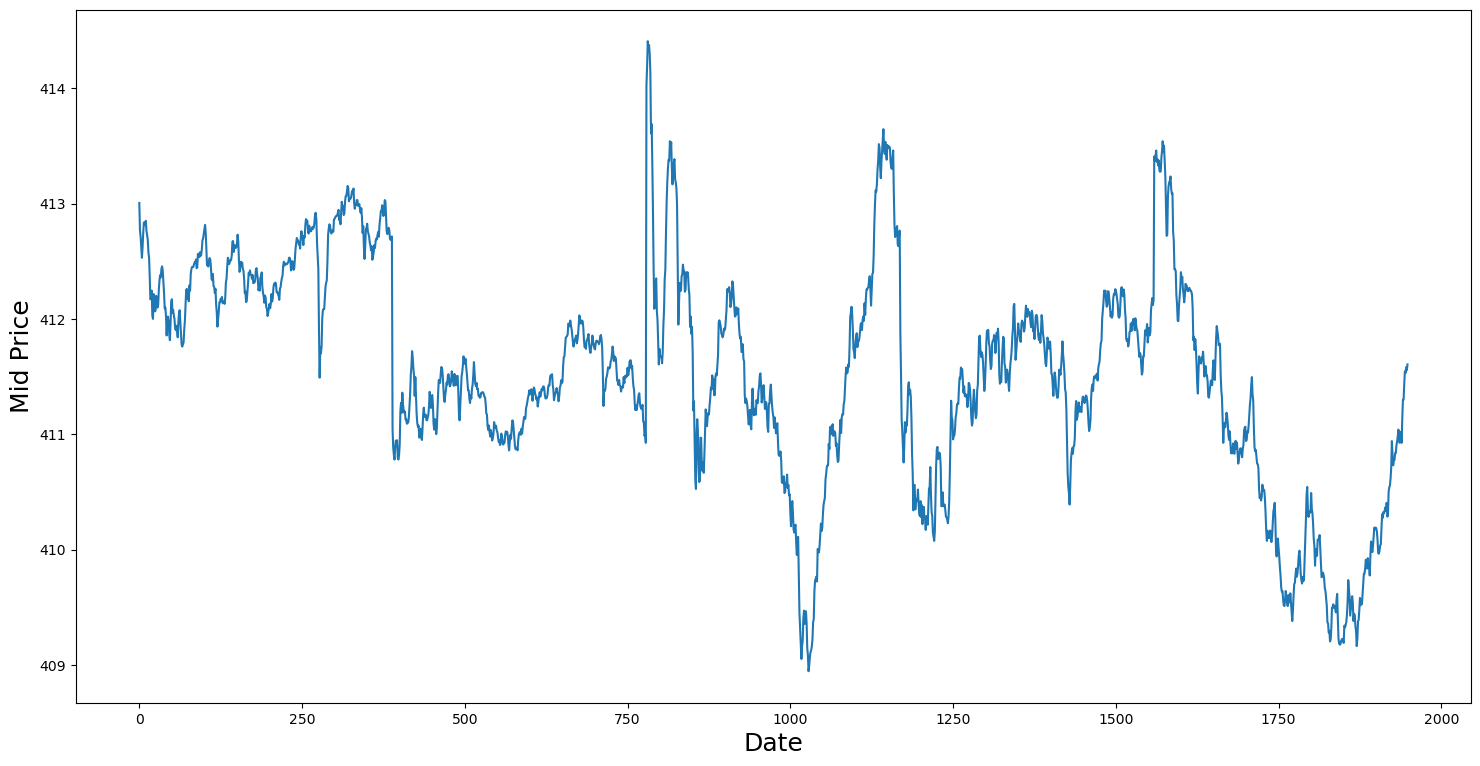

In [4]:
## NO CHANGES FROM HERE, JUST RUN EVERYTHING SEE NICE GRAPH


df = data.copy()
#df = df.rename(columns={'Datetime': 'Date'})
#visualization
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0) #we take an average
#plt.xticks(range(0,df.shape[0],500),df['Datetime'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [5]:
#let's try to predict the last 100% of values (this is arbitrary)
#default [1:3] = high + low
length = len(df)
train_len = math.ceil(1.0 * length)
print(train_len)
training_set = df.iloc[:train_len, 1:2].values
#print(training_set)
test_set = df.iloc[train_len:, 1:2].values #take the last x values? (to predict!)
print(test_set.shape)

1949
(0, 1)


In [6]:
sc = MinMaxScaler(feature_range = (0, 1)) #-->every scaled btwn 0-1, helps with variance
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, train_len-60):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(1829, 60, 1)


In [7]:
##TODO: Maybe tune the model such that LSTM units are changed?
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 100, batch_size = 256)

Epoch 1/100
8/8 [==============================] - 6s 180ms/step - loss: 0.1138
Epoch 2/100
8/8 [==============================] - 1s 182ms/step - loss: 0.0225
Epoch 3/100
8/8 [==============================] - 1s 177ms/step - loss: 0.0168
Epoch 4/100
8/8 [==============================] - 1s 174ms/step - loss: 0.0136
Epoch 5/100
8/8 [==============================] - 1s 178ms/step - loss: 0.0116
Epoch 6/100
8/8 [==============================] - 1s 181ms/step - loss: 0.0110
Epoch 7/100
8/8 [==============================] - 1s 175ms/step - loss: 0.0105
Epoch 8/100
8/8 [==============================] - 1s 179ms/step - loss: 0.0104
Epoch 9/100
8/8 [==============================] - 1s 177ms/step - loss: 0.0098
Epoch 10/100
8/8 [==============================] - 1s 178ms/step - loss: 0.0097
Epoch 11/100
8/8 [==============================] - 1s 179ms/step - loss: 0.0090
Epoch 12/100
8/8 [==============================] - 1s 181ms/step - loss: 0.0087
Epoch 13/100
8/8 [===================

In [8]:
###TO DO PREDICTION

### START AND END_DATES, GIVE YYYY-MM-DD format
start_date_p = "2023-05-22"

end_date_p = "2023-05-28"

### CHOOSE INTERVAL OF TRAINING DATA, BEWARNED THAT IF YOUR START AND END, LONG, MIGHT NOT BE ABLE TO GET LARGE INTERVAL 

time_interval_p = "1m" ## LIST OF HISTORY: [“1m”, “2m”, “5m”, “15m”, “30m”, “60m”,


data_p = pd.DataFrame(stock.history(start=start_date_p, end=end_date_p, interval=time_interval))
df_p = data_p.copy()
train_len_p = math.ceil(len(df_p) * 0.5)

print(train_len_p)
print(df_p)

975
                                 Open        High         Low       Close  \
Datetime                                                                    
2023-05-22 09:30:00-04:00  418.640015  418.970001  418.619995  418.820007   
2023-05-22 09:31:00-04:00  418.820007  418.869202  418.714996  418.804993   
2023-05-22 09:32:00-04:00  418.799988  418.920013  418.709991  418.864990   
2023-05-22 09:33:00-04:00  418.869995  419.429993  418.869995  419.364990   
2023-05-22 09:34:00-04:00  419.369995  419.670013  419.359985  419.589996   
...                               ...         ...         ...         ...   
2023-05-26 15:55:00-04:00  420.239990  420.489990  420.230011  420.454987   
2023-05-26 15:56:00-04:00  420.454987  420.470001  420.260010  420.339996   
2023-05-26 15:57:00-04:00  420.345001  420.359985  420.149994  420.299500   
2023-05-26 15:58:00-04:00  420.285004  420.285004  420.029999  420.070007   
2023-05-26 15:59:00-04:00  420.000000  420.109985  419.869995  420.00000

In [9]:
dataset_train = df_p.iloc[:train_len_p, 1:2]
print(len(dataset_train))
dataset_test = df_p.iloc[train_len_p:, 1:2]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)


print(dataset_total.shape)


inputs = dataset_total[:len(dataset_total) - len(dataset_test) - 60].values
inputs = inputs.reshape(-1,1)
print(inputs.shape)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, train_len_p):
    temp = inputs[i-60:i, 0]
    if len(temp) != 60:
        break
    X_test.append(temp)
X_test = np.array(X_test, dtype=np.float32)
print(X_test.shape)
X_test = X_test.reshape((X_test.shape[0], -1))
#reshape into 3D model for LSTM 
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) 

975
(1950, 1)
(915, 1)
(856, 60)


In [10]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print(len(predicted_stock_price))

27/27 [==============================] - 2s 17ms/step
856


(856, 1)


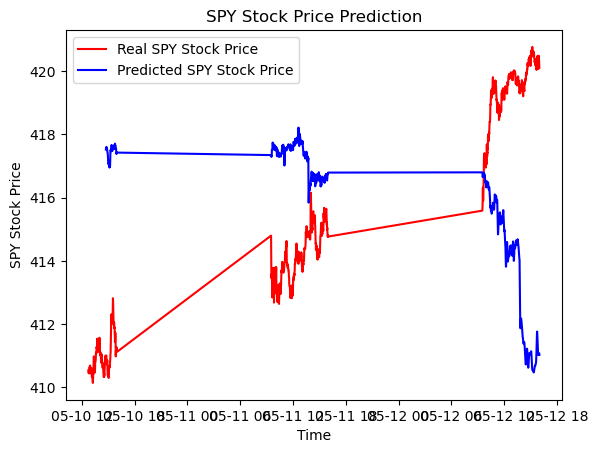

In [11]:
## to check prediction 
df_p =df.reset_index() #--> get rid of datetime as default index
plt.plot(df_p.loc[train_len_p - 1:, "Datetime"],dataset_test.values, color = "red", label = f'Real {stock_name} Stock Price')
print(predicted_stock_price.shape)
plt.plot(df_p.loc[train_len_p + 118:, "Datetime"],predicted_stock_price, color = "blue", label = f'Predicted {stock_name} Stock Price')
#plt.xticks(np.arange(118,1)) #this is just to clear the x-axis
plt.title(f'{stock_name} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{stock_name} Stock Price')
plt.legend()
plt.show()